In [4]:
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"

In [ ]:
# ✅ Clean Baseline QoR Model with GCN + LSTM + Focal Loss + Patient-wise Evaluation + Preprocessing

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# 🔧 Config
WINDOW_SIZE = 120
STRIDE = 10
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4


# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()


# 📦 Load and Normalize Data

df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# ✅ Normalize joint columns per patient using apply
joint_cols = [f'{j}_{axis}' for j in joints for axis in ['X', 'Y', 'Z']]
def normalize_joint_data(df):
    scaler = StandardScaler()
    def scale_group(group):
        group[joint_cols] = scaler.fit_transform(group[joint_cols])
        return group
    return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)

df = normalize_joint_data(df)

# 📚 Dataset
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, stride):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq = torch.tensor([
                    [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                aux_seq = torch.tensor([
                    [row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']] 
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((x_seq, aux_seq, label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# 🔀 Split
train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.3, random_state=42)
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]


train_dataset = WindowedDataset(train_df, WINDOW_SIZE, STRIDE)
test_dataset = WindowedDataset(test_df, WINDOW_SIZE, STRIDE)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ✅ Additions done. You can now train the model with these inputs.


C:\Users\RAZER\AppData\Local\Temp\ipykernel_23484\2413908337.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)


C:\Users\RAZER\AppData\Local\Temp\ipykernel_23484\1190691953.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)


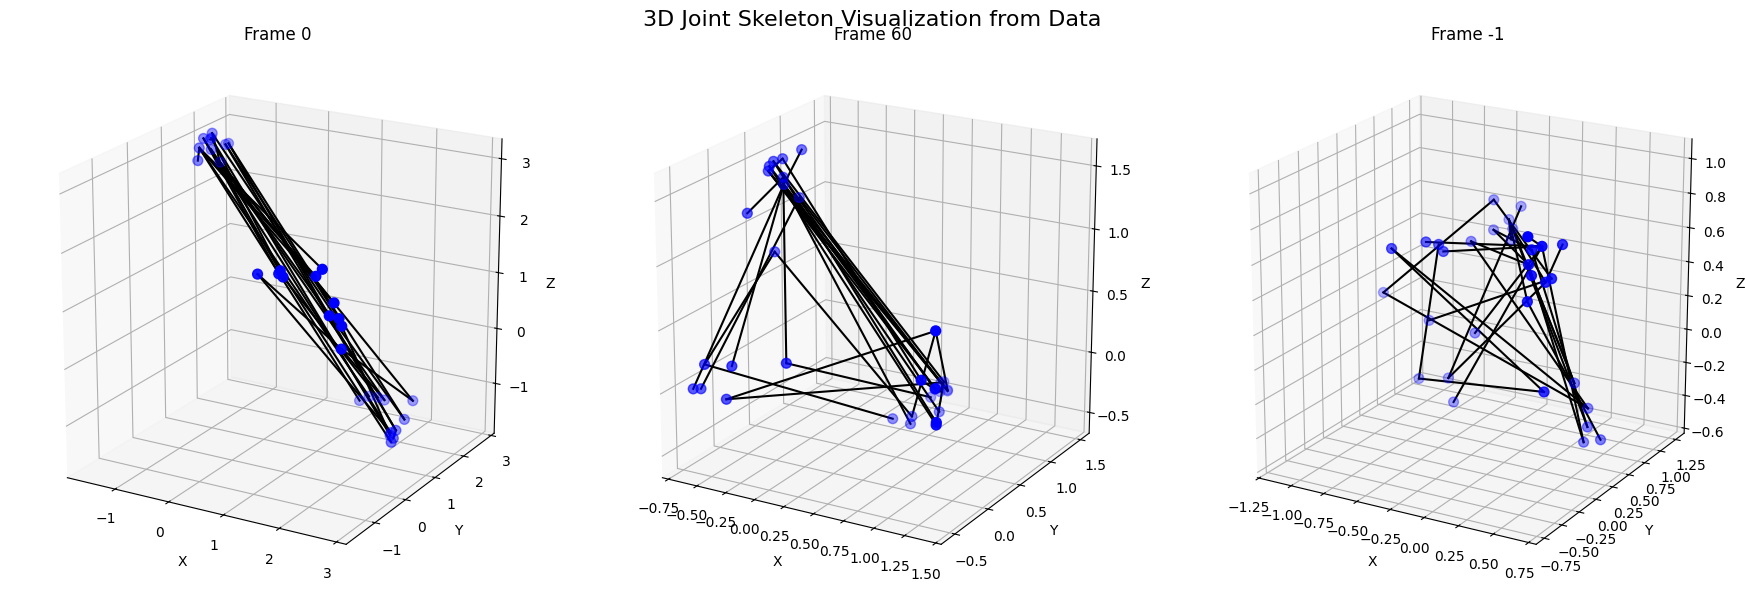

In [7]:
# Re-import necessary modules after kernel reset
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Reload graph structure info
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}

# Reload dataset
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# Normalize joint columns
joint_cols = [f'{j}_{axis}' for j in joints for axis in ['X', 'Y', 'Z']]
def normalize_joint_data(df):
    scaler = StandardScaler()
    def scale_group(group):
        group[joint_cols] = scaler.fit_transform(group[joint_cols])
        return group
    return df.groupby('patient_id').apply(scale_group).reset_index(drop=True)

df = normalize_joint_data(df)

# Build a visualization sample
window_size = 120
stride = 10
grouped = df.groupby(['patient_id', 'trial'])
samples = []

for (pid, trial), group in grouped:
    group = group.sort_values('t_uniform')
    if len(group) < window_size:
        continue
    for i in range(0, len(group) - window_size + 1, stride):
        window = group.iloc[i:i+window_size]
        x_seq = torch.tensor([
            [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z']] for j in joints]
            for _, row in window.iterrows()
        ], dtype=torch.float)
        samples.append(x_seq)
    break  # only take one patient-trial for plotting

x_seq = samples[0]  # take first example

# Now plot it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

frames_to_plot = [0, len(x_seq)//2, -1]
fig = plt.figure(figsize=(18, 6))

for i, frame_idx in enumerate(frames_to_plot):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    frame = x_seq[frame_idx]
    xs, ys, zs = frame[:, 0].numpy(), frame[:, 1].numpy(), frame[:, 2].numpy()
    ax.scatter(xs, ys, zs, c='blue', s=50)
    for a, b in edges:
        a_idx, b_idx = joint_to_idx[a], joint_to_idx[b]
        ax.plot([xs[a_idx], xs[b_idx]], [ys[a_idx], ys[b_idx]], [zs[a_idx], zs[b_idx]], c='black')
    ax.set_title(f'Frame {frame_idx}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=20, azim=-60)
    ax.set_box_aspect([1,1,1])

plt.suptitle("3D Joint Skeleton Visualization from Data", fontsize=16)
plt.tight_layout()
plt.show()
